# Global Convexity

## Imports

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import seaborn as sns
import random
random.seed(42)
import time
from sortedcontainers import SortedList

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
TSPA_PATH = "../data/TSPA.csv"
TSPB_PATH = "../data/TSPB.csv"

In [3]:
df = pd.read_csv(TSPA_PATH, sep=";", header=None)
df.columns = ["x", "y", "val"]
df

,x,y,val
0,1355,1796,496
1,2524,387,414
2,2769,430,500
3,3131,1199,1133
4,661,87,903
...,...,...,...
195,189,1151,1145
196,3688,759,727
197,973,984,1637
198,910,1383,1255


## Utils

In [4]:
def math_round(n):
    '''
    Mathematically rounds up to the nearest integer, always rounds up for 0.5

    ParametersL
    n: floating point number to round
    '''
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [5]:
def plot_nodes_with_lines(df, connections=None):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = 'Nodes with Color-Scaled Values' if connections is None else 'Nodes with Values and Connections'
    plt.title(title)
    plt.grid(False)
    plt.show()


def get_distance_matrix(df, distance_function):
    """
    Calculates the distance matrix for a set of nodes using the given distance function.

    Parameters:
    nodes: DataFrame of nodes, each with 'x', 'y', and 'val'.
    distance_function: function that takes two points (x1, y1) and (x2, y2) and returns the distance.

    Returns:
    A 2D numpy array representing the distance matrix.
    """
    positions = df[["x", "y"]]
    num_nodes = len(positions)
    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=np.int64)

    for i in range(num_nodes):
        for j in range(i, num_nodes):
            dist = round(distance_function(positions.iloc[i], positions.iloc[j]))
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    return distance_matrix


def calculate_score(solution, matrix, weights):
    '''
    Calculates solution score based on the matrix of distances and provided weights array.

    Parameters:
    solution: List or array of the solution
    matrix: Numpy array with node distances (2D)
    weights: Numpy array with node weights (1D - vector)
    '''
    score = 0
    for i in range(len(solution)-1):
        node_1 = solution[i]
        node_2 = solution[i+1]
        score += (matrix[node_1][node_2] + weights[node_1])
    node_1 = solution[-1]
    node_2 = solution[0]
    score += (matrix[node_1][node_2] + weights[node_1])
    return score

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [6]:
def find_second_node_closest(start_node, matrix, weights):
    '''
    Finds the second node for the TSP cycle using a greedy approach, selecting the node closest
    to the start node based on the distance matrix and weights.

    Parameters:
    start_node: int, the index of the node from which the search for the second node starts.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    second_node: int, the index of the second node selected to form the initial cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    np.fill_diagonal(distance_matrix, np.inf)
    second_node = np.argmin(distance_matrix[:, start_node] + weights)
    return second_node

def find_second_node_regret(start_node, non_cycle_nodes, matrix, weights):
    '''
    Finds the second node using a regret-based heuristic. The regret is calculated as the difference 
    between the closest and second closest nodes, and the node with the highest regret is selected.

    Parameters:
    start_node: int, the index of the node from which the cycle starts.
    non_cycle_nodes: set of remaining nodes that are not yet in the cycle.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    best_node: int, the index of the selected second node based on the regret heuristic.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    best_node = None
    best_regret = -np.inf
    for node in non_cycle_nodes:
        start_node_cost = distance_matrix[start_node][node] + weights[node]
        distance_matrix[start_node][node] = np.inf
        smallest_cost = np.argmin(distance_matrix[node] + weights)
        regret = smallest_cost - start_node_cost
        if regret > best_regret:
            best_regret = regret
            best_node = node
    return best_node

def find_third_node(node_1, node_2, matrix, weights):
    '''
    Finds the third node for the TSP cycle by selecting the node that minimizes the total 
    distance from both the first and second nodes, considering node weights.

    Parameters:
    node_1: int, the index of the first node.
    node_2: int, the index of the second node.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    third_node: int, the index of the third node to complete the initial triangle of the cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    np.fill_diagonal(distance_matrix, np.inf)
    third_node = np.argmin(distance_matrix[:, node_1] + distance_matrix[:, node_2] + weights)
    return third_node


def calculate_score_three(solution, matrix, weights):
    '''
    Calculates the score (total distance) for a TSP cycle for the first three nodes. 

    Parameters:
    solution: list of three ints representing the node indices of the current cycle.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    '''
    score = 0
    node_1 = solution[0]
    node_2 = solution[1]
    node_3 = solution[2]
    score += matrix[node_1][node_2] + weights[node_1]
    score += matrix[node_2][node_3] + weights[node_2]
    score += matrix[node_3][node_1] + weights[node_3]
    return score

def update_score(solution, score, node, insert_location, matrix, weights):
    '''
    Updates the total score after inserting a node at a specified location in the solution. 

    Parameters:
    solution: List of nodes representing the current cycle.
    score: The current total score (cost) of the cycle before the node is inserted.
    node: int, the node to be inserted into the solution.
    insert_location: int, the index at which the node will be inserted.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    '''
    node_before = solution[insert_location - 1]
    node_after = solution[insert_location]
    score -= matrix[node_before][node_after]
    score += matrix[node_before][node] + matrix[node][node_after] + weights[node]
    return score

def find_second_node_closest_weighted(start_node, non_cycle_nodes, matrix, weights, regret_weight):
    '''
    Finds the second node for the TSP cycle using a mix of a weighted greedy and regret approaches
    to the start node based on the distance matrix and weights.

    Parameters:
    start_node: int, the index of the node from which the search for the second node starts.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    second_node: int, the index of the second node selected to form the initial cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)

    greedy_scores = []
    ordered_nodes = list(non_cycle_nodes)
    for node in non_cycle_nodes:
        greedy_score = distance_matrix[start_node][node] + weights[node]
        greedy_scores.append(greedy_score)

    regret_scores = []
    for node in non_cycle_nodes:
        start_node_cost = distance_matrix[start_node][node] + weights[node]
        distance_matrix[start_node][node] = np.inf
        smallest_cost = np.argmin(distance_matrix[node] + weights)
        regret = smallest_cost - start_node_cost
        regret_scores.append(regret)

    greedy_scores = np.array(greedy_scores)
    regret_scores = np.array(regret_scores)
    total_scores = ((1 + regret_weight) * greedy_score) + (regret_weight * regret_scores)
    total_scores, ordered_nodes = zip(*sorted(zip(total_scores, ordered_nodes)))
    return ordered_nodes[0]

## Random

In [7]:
def random_solution(distance_matrix, weights, start_node):
    '''
    Returns a random solution to the TSP problem based on the provided distance matrix.

    Parameters:
    distance_matrix: numpy.array containing distances between the nodes.
    weights: numpy.array containing the weights associated with each node.
    start_node: int, the index of the node from which the cycle starts.
    '''

    remaining_nodes = list(range(len(distance_matrix)))
    remaining_nodes.remove(start_node)
    np.random.shuffle(remaining_nodes)
    solution = [start_node] + remaining_nodes[:len(distance_matrix)//2 - 1]
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

In [8]:
distance_matrix = get_distance_matrix(df, euclidean_distance)
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,1831,1966,1874,1845,1097,1658,2297,2193,1364,...,1977,746,1414,993,1527,1333,2553,897,607,1100
1,1831,0,249,1014,1887,1985,802,1872,1270,1027,...,2173,2104,2213,2215,1016,2457,1222,1662,1897,2600
2,1966,249,0,850,2136,2209,1050,1698,1066,981,...,2421,2301,2447,2426,1264,2679,976,1880,2089,2796
3,1874,1014,850,0,2709,2513,1715,858,344,512,...,2976,2442,2809,2632,1861,2942,710,2169,2229,2907
4,1845,1887,2136,2709,0,888,1091,3487,3036,2396,...,288,1352,780,1214,874,1164,3101,950,1320,1632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1333,2457,2679,2942,1164,473,1834,3537,3286,2486,...,1087,587,384,342,1587,0,3521,802,757,523
196,2553,1222,976,710,3101,3068,2023,1124,517,1212,...,3384,3063,3338,3231,2227,3521,0,2724,2847,3545
197,897,1662,1880,2169,950,345,1113,2824,2513,1741,...,1085,529,649,563,890,802,2724,0,404,987
198,607,1897,2089,2229,1320,497,1462,2785,2569,1752,...,1409,216,807,419,1260,757,2847,404,0,708


In [9]:
weights = df.val.to_numpy()
weights[:2]

array([496, 414], dtype=int64)

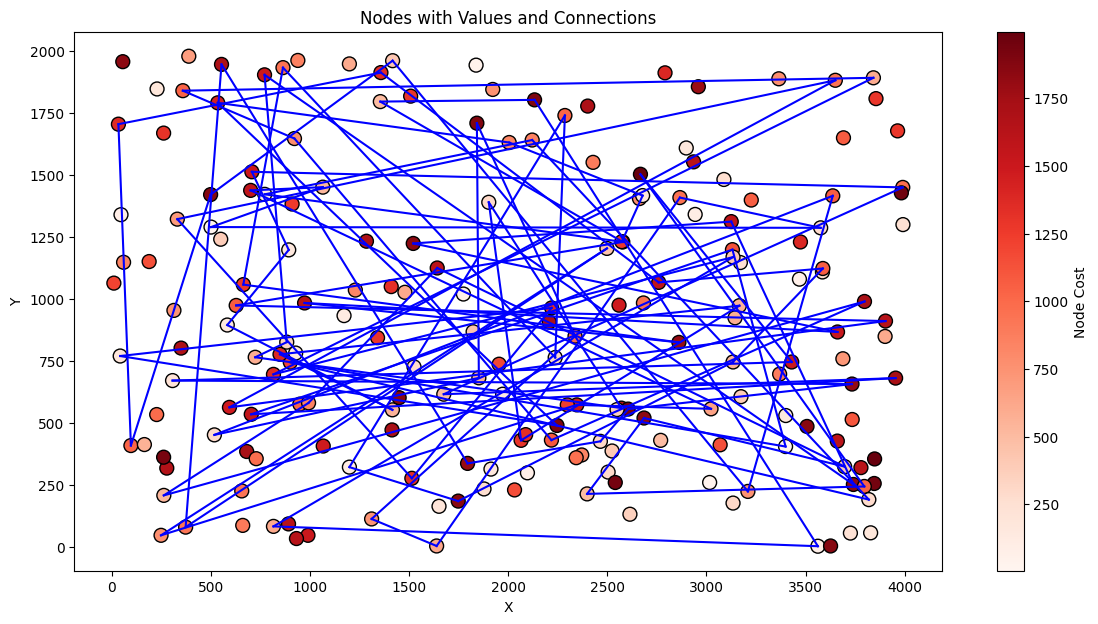

Achieved Score: 273509


In [10]:
start_solution, start_score = random_solution(distance_matrix, weights, start_node = 0)
plot_nodes_with_lines(df, start_solution)
print(f"Achieved Score: {start_score}")

## Greedy Local Search with Edges

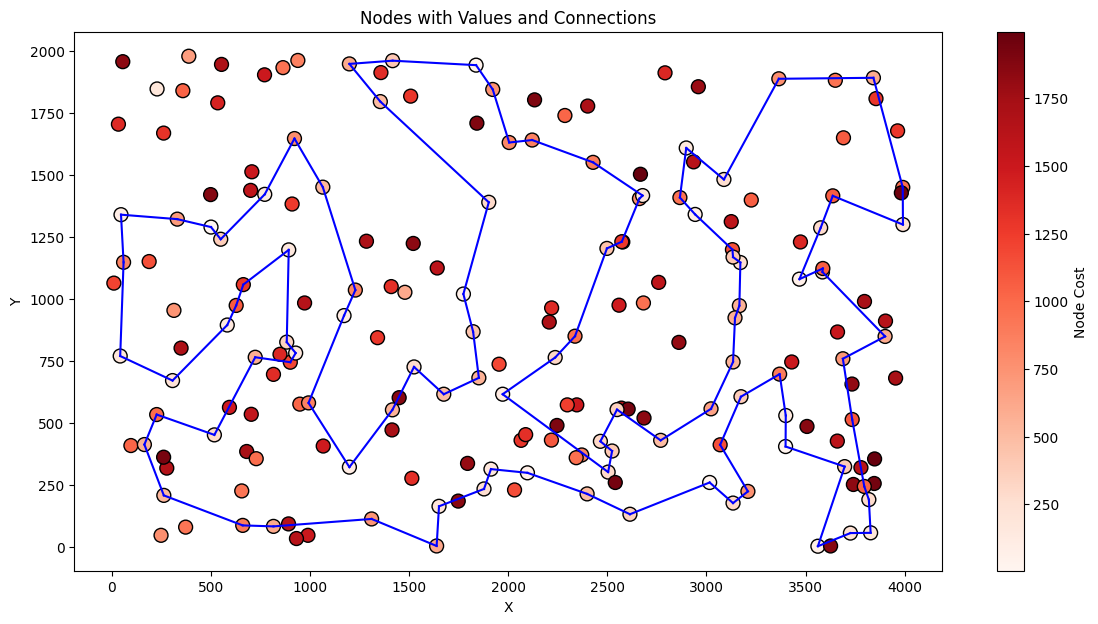

Acheived Total Score: 73767


In [11]:
def update_score_intra(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    if int(abs(cycle_position - any_node_position)) > 1 and int(abs(cycle_position - any_node_position)) < 99:
        node_1 = solution[cycle_position]
        node_2 = solution[any_node_position]
        node_before_1 = solution[cycle_position-1]
        if cycle_position + 1 == num_cycle_nodes:
            node_after_1 = solution[0]
        else:
            node_after_1 = solution[cycle_position+1]

        node_before_2 = solution[any_node_position-1]
        if any_node_position + 1 == num_cycle_nodes:
            node_after_2 = solution[0]
        else:
            node_after_2 = solution[any_node_position+1]

        temp_score -= distance_matrix[node_1][node_before_1]
        temp_score -= distance_matrix[node_1][node_after_1]
        temp_score -= distance_matrix[node_2][node_before_2]
        temp_score -= distance_matrix[node_2][node_after_2]
        temp_score += distance_matrix[node_1][node_before_2]
        temp_score += distance_matrix[node_1][node_after_2]
        temp_score += distance_matrix[node_2][node_before_1]
        temp_score += distance_matrix[node_2][node_after_1]
    else:
        if cycle_position < any_node_position:
            cycle_position, any_node_position = any_node_position, cycle_position
        node_1 = solution[cycle_position]
        node_2 = solution[any_node_position]
        if cycle_position + 1 == num_cycle_nodes and any_node_position + 2 == num_cycle_nodes:
            node_after_1 = solution[0]
        elif cycle_position + 1 == num_cycle_nodes and any_node_position == 0:
            node_after_1 = solution[cycle_position - 1]
        else:
            node_after_1 = solution[cycle_position + 1]
        
        if cycle_position + 1 == num_cycle_nodes and any_node_position == 0:
            node_before_2 = solution[any_node_position + 1]
        else:
            node_before_2 = solution[any_node_position - 1]
        temp_score -= distance_matrix[node_1][node_after_1]
        temp_score -= distance_matrix[node_2][node_before_2]
        temp_score += distance_matrix[node_1][node_before_2]
        temp_score += distance_matrix[node_2][node_after_1]
    return temp_score


def node_intra_change(score, improvement, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    temp_score = score
    temp_score = update_score_intra(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
    if temp_score < score:
        solution[cycle_position], solution[any_node_position] = solution[any_node_position], solution[cycle_position]
        score = temp_score
        improvement = True
    return score, improvement, solution

def update_score_inter(temp_score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    node_1 = solution[cycle_position]
    node_2 = remaining_nodes[relative_node_position]
    node_before = solution[cycle_position-1]
    if cycle_position + 1 == num_cycle_nodes:
        node_after = solution[0]
    else:
        node_after = solution[cycle_position+1]
    temp_score -= distance_matrix[node_1][node_before]
    temp_score -= distance_matrix[node_1][node_after]
    temp_score -= weights[node_1]
    temp_score += distance_matrix[node_2][node_before]
    temp_score += distance_matrix[node_2][node_after]
    temp_score += weights[node_2]
    return temp_score

def node_inter_change(score, improvement, solution, cycle_position, any_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    temp_score = score
    relative_node_position = any_node_position - num_cycle_nodes
    temp_score = update_score_inter(temp_score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
    if temp_score < score:
        solution[cycle_position], remaining_nodes[relative_node_position] = remaining_nodes[relative_node_position], solution[cycle_position]
        score = temp_score
        improvement = True
    return score, improvement, solution

def greedy_local_search(solution, score, distance_matrix, weights):
    all_node_positions = [i for i in range(len(weights))]
    cycle_positions = [i for i in range(len(solution))]
    remaining_nodes = list(set(all_node_positions) - set(solution))
    num_cycle_nodes = len(solution)
    moves = []
    for cycle_position in cycle_positions:
        for any_node in all_node_positions:
            if cycle_position < any_node:
                moves.append((cycle_position, any_node))
    improvement = True
    while improvement:
        improvement = False
        random.shuffle(moves)
        for cycle_position, any_node_position in moves:
            if any_node_position >= num_cycle_nodes:
                score, improvement, solution = node_inter_change(score, improvement, solution, cycle_position, any_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            else:
                score, improvement, solution = node_intra_change(score, improvement, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
            if improvement:
                break
    return solution, score

def update_score_intra_edge(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    # cycle position, any node position - positions of nodes in the solution that mark the beginning of selected edge
    temp_score -= distance_matrix[solution[cycle_position]][solution[cycle_position+1]]
    temp_score -= distance_matrix[solution[any_node_position]][solution[(any_node_position + 1) % num_cycle_nodes]]

    temp_score += distance_matrix[solution[cycle_position]][solution[any_node_position]]
    temp_score += distance_matrix[solution[cycle_position+1]][solution[(any_node_position + 1) % num_cycle_nodes]]
    return temp_score

def edge_intra_change(score, improvement, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    temp_score = score
    temp_score = update_score_intra_edge(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
    if temp_score < score:
        solution[cycle_position+1:any_node_position+1] = solution[cycle_position+1:any_node_position+1][::-1]
        score = temp_score
        improvement = True

    return score, improvement, solution

def greedy_local_search_edges(solution, score, distance_matrix, weights):
    all_node_positions = [i for i in range(len(weights))]
    cycle_positions = [i for i in range(len(solution))]
    remaining_nodes = list(set(all_node_positions) - set(solution))
    remaining_positions = list(set(all_node_positions) - set(cycle_positions))
    num_cycle_nodes = len(solution)

    moves = []
    for cycle_position in cycle_positions:
        # Consider only inter moves for two-nodes exchange
        for any_node in remaining_positions:
            moves.append((cycle_position, any_node))

        # Consider intra edges for edge exchange (edge starting nodes added to moves)
        for any_node in range(cycle_position + 2, num_cycle_nodes):
            if (cycle_position == 0 and any_node == num_cycle_nodes - 1):
                continue
            moves.append((cycle_position, any_node))

    improvement = True
    while improvement:
        improvement = False
        random.shuffle(moves)
        for cycle_position, any_node_position in moves:
            if any_node_position >= num_cycle_nodes:
                score, improvement, solution = node_inter_change(score, improvement, solution, cycle_position, any_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            else:
                score, improvement, solution = edge_intra_change(score, improvement, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
            if improvement:
                break
    return solution, score

start_solution, start_score = random_solution(distance_matrix, weights, start_node = 0)
solution, score = greedy_local_search_edges(start_solution.copy(), start_score.copy(), distance_matrix, weights)
plot_nodes_with_lines(df, solution)
print(f"Acheived Total Score: {score}")

## Large Neighborhood

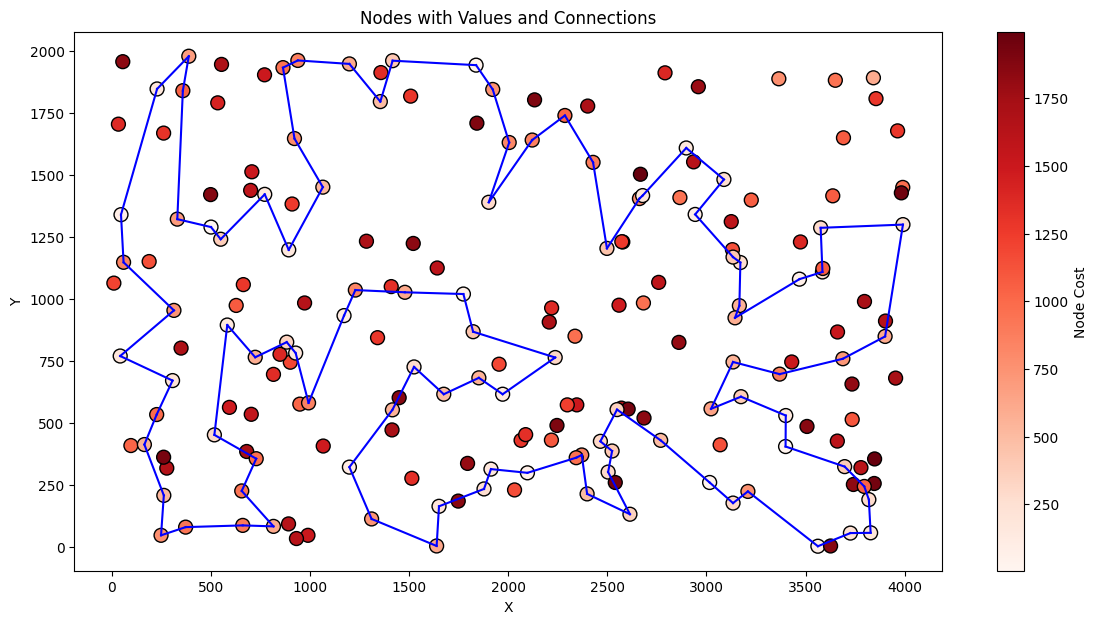

Achieved Total Score: 69511
Number of iterations: 364


In [12]:
def update_score_inter_delta(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    '''
    Calculates the score after changing the node with an outside node in remaining_nodes. Only used when a new move appears.
    '''
    node_1 = solution[cycle_position]
    node_2 = remaining_nodes[relative_node_position]
    node_before = solution[cycle_position - 1]
    node_after = solution[(cycle_position + 1) % num_cycle_nodes]
    score -= distance_matrix[node_1][node_before]
    score -= distance_matrix[node_1][node_after]
    score -= weights[node_1]
    score += distance_matrix[node_2][node_before]
    score += distance_matrix[node_2][node_after]
    score += weights[node_2]
    return score

def update_score_inter_edge_delta(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    '''
    Calculates the score after changing the solution by exchanging edges. Only used when a new move appears.
    '''
    temp_score -= distance_matrix[solution[cycle_position]][solution[cycle_position+1]]
    temp_score -= distance_matrix[solution[any_node_position]][solution[(any_node_position + 1) % num_cycle_nodes]]

    temp_score += distance_matrix[solution[cycle_position]][solution[any_node_position]]
    temp_score += distance_matrix[solution[cycle_position+1]][solution[(any_node_position + 1) % num_cycle_nodes]]
    return temp_score

def node_intra_change_steepest_fast_delta(move_score, score, solution, cycle_position, relative_node_position, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index):
    '''
    Calculates the new solution and score after applying a move by exchanging node with a node from remaining_nodes. Also updates indexes and sets.
    '''
    solution_set.remove(solution[cycle_position])
    solution_set.add(remaining_nodes[relative_node_position])
    remaining_nodes_set.add(solution[cycle_position])
    remaining_nodes_set.remove(remaining_nodes[relative_node_position])
    solution_index[remaining_nodes[relative_node_position]] = cycle_position
    remaining_nodes_index[solution[cycle_position]] = relative_node_position
    solution[cycle_position], remaining_nodes[relative_node_position] = remaining_nodes[relative_node_position], solution[cycle_position]
    return score + move_score, solution, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index

def edge_inter_change_steepest_fast_delta(move_score, score, solution, cycle_position, any_node_position, solution_index):
    '''
    Calculates the new solution and score after applying a move by exchanging edges. Also updates indexes and sets.
    '''
    solution[cycle_position+1:any_node_position+1] = solution[cycle_position+1:any_node_position+1][::-1]
    for i in range(cycle_position + 1, any_node_position + 1):
        solution_index[solution[i]] = i
    return score + move_score, solution, solution_index

def get_initial_moves(solution, cycle_positions, remaining_positions, num_cycle_nodes, score, remaining_nodes, distance_matrix, weights):
    '''
    Produces the initial moves.
    '''
    moves = SortedList()
    already_added_inter = set()
    already_added_edges = set()

    for cycle_position in cycle_positions:
        for relative_node_position in range(len(remaining_positions)):
            temp_score = update_score_inter_delta(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            move_score = temp_score - score
            node_before = solution[cycle_position - 1]
            node_after = solution[(cycle_position + 1) % num_cycle_nodes]
            already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], node_before, node_after))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], node_before, node_after), 0)) # 0 for intra

        for any_node_position in range(cycle_position + 2, num_cycle_nodes):
            if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
                continue
            temp_score = update_score_inter_edge_delta(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
            move_score = temp_score - score
            node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
            node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
            already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1)) # 1 for inter

    return moves, already_added_inter, already_added_edges

def update_moves_intra_delta(score, solution, moves, already_added_inter, already_added_edges, cycle_position, remaining_positions, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    '''
    Updates moves after an echange of nodes.
    '''
    for relative_node_position in range(len(remaining_positions)):
        prev_node = solution[cycle_position - 1]
        next_node = solution[(cycle_position + 1) % num_cycle_nodes]
        if (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node) in already_added_inter:
            continue
        temp_score = update_score_inter_delta(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
        move_score = temp_score - score
        already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node))
        if move_score >= 0:
            continue
        moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node), 0))

    for any_node_position in range(cycle_position + 2, num_cycle_nodes):
        if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
            continue
        node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
        node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
        if (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2) in already_added_edges:
            continue
        temp_score = update_score_inter_edge_delta(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
        move_score = temp_score - score
        already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
        if move_score >= 0:
            continue
        moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1))
        
    return moves, already_added_inter, already_added_edges

def update_moves_inter_edge_delta(score, cycle_positions, solution, moves, num_cycle_nodes, distance_matrix, remaining_nodes, already_added_inter, already_added_edges, remaining_positions, weights):
    '''
    Updates the moves after an exchange of edges.
    '''
    for cycle_position in cycle_positions:
        for any_node_position in range(cycle_position + 2, num_cycle_nodes):
            if (cycle_position == 0 and any_node_position == num_cycle_nodes - 1):
                continue
            node_context_1 = solution[(cycle_position + 1) % num_cycle_nodes]
            node_context_2 = solution[(any_node_position + 1) % num_cycle_nodes]
            if (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2) in already_added_edges:
                continue
            temp_score = update_score_inter_edge_delta(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
            move_score = temp_score - score
            already_added_edges.add((solution[cycle_position], solution[any_node_position], node_context_1, node_context_2))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], solution[any_node_position], node_context_1, node_context_2), 1))

    for cycle_position in cycle_positions:
        for relative_node_position in range(len(remaining_positions)):
            prev_node = solution[cycle_position - 1]
            next_node = solution[(cycle_position + 1) % num_cycle_nodes]
            if (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node) in already_added_inter:
                continue
            temp_score = update_score_inter_delta(score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            move_score = temp_score - score
            already_added_inter.add((solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node))
            if move_score >= 0:
                continue
            moves.add((move_score, (solution[cycle_position], remaining_nodes[relative_node_position], prev_node, next_node), 0))

    return moves, already_added_inter, already_added_edges

def init_index_dict(values):
    '''
    Creates a dictionary of of indexes for each value.
    '''
    index_dict = {}
    for i in range(len(values)):
        index_dict[values[i]] = i
    return index_dict

def deltas_steepest_local_search_edges(solution, score, distance_matrix, weights):
    num_cycle_nodes = len(solution)
    all_node_positions = [i for i in range(len(weights))]
    cycle_positions = [i for i in range(num_cycle_nodes)]
    remaining_nodes = list(set(all_node_positions) - set(solution))
    remaining_positions = list(set(all_node_positions) - set(cycle_positions))
    solution_set = set(solution)
    remaining_nodes_set = set(remaining_nodes)
    solution_index = init_index_dict(solution)
    remaining_nodes_index = init_index_dict(remaining_nodes)

    moves, already_added_inter, already_added_edges = get_initial_moves(solution, cycle_positions, remaining_positions, num_cycle_nodes, score, remaining_nodes, distance_matrix, weights)
    i = 0
    while i < len(moves):
        move_score, move, inter = moves[i]
        if not inter:
            cycle_node, any_node, node_before, node_after = move
            if cycle_node not in solution_set or any_node not in remaining_nodes_set:
                moves.remove(moves[i])
                already_added_inter.remove(move)
                continue
            cycle_position = solution_index[cycle_node]
            if node_before != solution[cycle_position - 1] or node_after != solution[(cycle_position + 1) % num_cycle_nodes]:
                moves.remove(moves[i])
                already_added_inter.remove(move)
                continue
            relative_node_position = remaining_nodes_index[any_node]
            score, solution, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index = node_intra_change_steepest_fast_delta(move_score, score, solution, cycle_position, relative_node_position, remaining_nodes, solution_set, remaining_nodes_set, solution_index, remaining_nodes_index)
            moves, already_added_inter, already_added_edges = update_moves_intra_delta(score, solution, moves, already_added_inter, already_added_edges, cycle_position, remaining_positions, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            i = 0
        else:
            if move[0] not in solution_set or move[1] not in solution_set:
                moves.remove(moves[i])
                already_added_edges.remove(move)
                continue
            cycle_node, any_node, node_after_cycle, node_after_any = move
            cycle_position = solution_index[cycle_node]
            any_node_position = solution_index[any_node]
            if cycle_position > any_node_position:
                i += 1
                continue # We got turned around ;(
            if node_after_cycle != solution[(cycle_position + 1) % num_cycle_nodes] or node_after_any != solution[(any_node_position + 1) % num_cycle_nodes]:
                moves.remove(moves[i])
                already_added_edges.remove(move)
                continue
            score, solution, solution_index = edge_inter_change_steepest_fast_delta(move_score, score, solution, cycle_position, any_node_position, solution_index)
            moves, already_added_inter, already_added_edges = update_moves_inter_edge_delta(score, cycle_positions, solution, moves, num_cycle_nodes, distance_matrix, remaining_nodes, already_added_inter, already_added_edges, remaining_positions, weights)
            i = 0

    return solution, score

def update_insert_score(solution, score, node, insert_location, matrix, weights):
    node_before = solution[insert_location - 1]
    node_after = solution[insert_location]
    score -= matrix[node_before][node_after]
    score += matrix[node_before][node] + matrix[node][node_after] + weights[node]
    return score

def Large_Neighborhood_Search(distance_matrix, weights, initial_algorithm, steepest_algorithm, \
                              num_nodes, allowed_time, destroy, repair, optional_steepest = True, df = None, \
                                num_destroy_nodes=30):
    start_time = time.time()
    end_time = start_time
    random_start = np.random.randint(0, num_nodes)
    current_solution, current_score = initial_algorithm(distance_matrix, weights, start_node=random_start)
    current_solution, current_score = steepest_algorithm(current_solution, current_score, distance_matrix, weights)
    best_solution = current_solution.copy()
    best_score = current_score
    num_iterations = 0
    while (end_time - start_time) < allowed_time:
        num_iterations += 1
        current_solution, current_score, removed_nodes = destroy(current_solution, current_score,\
                                                        distance_matrix, weights, \
                                                        num_total_nodes = num_nodes, \
                                                        num_destroy_nodes = num_destroy_nodes)
        current_solution, current_score = repair(current_solution, current_score, \
                                                 removed_nodes, distance_matrix, weights, num_destroy_nodes, df=df)
        # print(best_score, current_score)    
        if optional_steepest:
            current_solution, current_score = steepest_algorithm(current_solution, current_score, distance_matrix, weights)
            # print(current_score)

        if current_score < best_score:
            best_score = current_score
            best_solution = current_solution.copy()
        else:
            current_score = best_score
            current_solution = best_solution.copy()
        
        end_time = time.time()
        
        # break
    
    return best_solution, best_score, num_iterations

def destroy(current_solution, current_score, distance_matrix, weights, num_total_nodes, num_destroy_nodes):
    start_node = np.random.randint(0, num_total_nodes - 1)
    end_node = start_node + num_destroy_nodes
    
    current_score -= distance_matrix[current_solution[start_node - 1]][current_solution[start_node]]
    current_score -= distance_matrix[current_solution[(end_node-1)%num_total_nodes]][current_solution[end_node%num_total_nodes]]
    current_score += distance_matrix[current_solution[end_node%num_total_nodes]][current_solution[start_node-1]]

    if end_node >= num_total_nodes:
        removed_nodes = current_solution[start_node:] + current_solution[:end_node % num_total_nodes]
        
        current_score -= np.sum(distance_matrix[removed_nodes[:-1], removed_nodes[1:]])
        current_score -= np.sum(weights[removed_nodes])
        
        current_solution = np.array(current_solution)
        current_solution = np.delete(current_solution, list(range(start_node, num_total_nodes)) \
                                      + list(range(0, end_node % num_total_nodes)))
        current_solution = list(current_solution)
        # print("E")

    else:
        removed_nodes = current_solution[start_node:end_node]
        # print(len(removed_nodes))

        current_score -= np.sum(distance_matrix[removed_nodes[:-1], removed_nodes[1:]])
        current_score -= np.sum(weights[removed_nodes])
        
        del current_solution[start_node:end_node]

    # print(current_score, calculate_score(current_solution, distance_matrix, weights), len(current_solution))
    return current_solution, current_score, removed_nodes

def repair_nn_all(current_solution, current_score, removed_nodes, matrix, weights, num_destroy_nodes, df=None):
    available_nodes = set(range(len(weights))) - set(current_solution)
    while num_destroy_nodes > 0:
        best_score = np.inf
        best_node = None
        best_location = None
        
        for node in list(available_nodes):
            score_locations = []
            scores = []
        
            for insert_location in range(len(current_solution)):
                #insert_location = (insert_location + 1) % len(solution) MIGHT NEED TO UNCOMMENT THIS
                temp_score = update_insert_score(current_solution, current_score, node, insert_location, matrix, weights)
                score_locations.append(insert_location)
                scores.append(temp_score)
        
            scores, score_locations = zip(*sorted(zip(scores, score_locations)))
        
            if scores[0] < best_score:
                best_node = node
                best_location = score_locations[0]
                best_score = scores[0]
        
        current_solution.insert(best_location, best_node)
        current_score = best_score
        available_nodes.remove(best_node)
        num_destroy_nodes -= 1
    
    return current_solution, current_score

def repair_nn_all_removed(current_solution, current_score, removed_nodes, matrix, weights, df=None):
    # plot_nodes_with_lines(df, current_solution, cycle=False)
    # print(current_score, calculate_score(current_solution, matrix, weights), len(current_solution))
    while len(removed_nodes) > 0:
        best_score = np.inf
        best_node = None
        best_location = None
        
        for node in removed_nodes:
            score_locations = []
            scores = []
        
            for insert_location in range(len(current_solution)):
                #insert_location = (insert_location + 1) % len(solution) MIGHT NEED TO UNCOMMENT THIS
                temp_score = update_insert_score(current_solution, current_score, node, insert_location, matrix, weights)
                score_locations.append(insert_location)
                scores.append(temp_score)
        
            scores, score_locations = zip(*sorted(zip(scores, score_locations)))
        
            if scores[0] < best_score:
                best_node = node
                best_location = score_locations[0]
                best_score = scores[0]
        
        current_solution.insert(best_location, best_node)
        current_score = best_score
        removed_nodes.remove(best_node)

    # plot_nodes_with_lines(df, current_solution)

    # print(current_score, calculate_score(current_solution, matrix, weights), len(current_solution))
    # current_score = calculate_score(current_solution, matrix, weights)
    # print(current_score)
    
    return current_solution, current_score


def repair_weighted_regret(current_solution, current_score, removed_nodes, matrix, weights, \
                            num_destroy_nodes, df=None, regret_weight=-0.5):
    
    available_nodes = set(range(len(weights))) - set(current_solution)
    while num_destroy_nodes > 0:
        best_weighted_score = np.inf
        best_score = None
        best_node = None
        best_location = None
                
        for node in list(available_nodes):
            score_locations = []
            scores = []
        
            for insert_location in range(len(current_solution)):
                #insert_location = (insert_location + 1) % len(solution) MIGHT NEED TO UNCOMMENT THIS
                temp_score = update_insert_score(current_solution, current_score, node, insert_location, matrix, weights)
                score_locations.append(insert_location)
                scores.append(temp_score)
        
            scores, score_locations = zip(*sorted(zip(scores, score_locations)))
            regret = scores[1] - scores[0]
            regret_location = score_locations[0]
            score_difference = scores[0] - current_score
            weghted_score = ((1 + regret_weight) * score_difference) + (regret_weight * regret)
        
            if weghted_score < best_weighted_score:
                best_weighted_score = weghted_score
                best_node = node
                best_location = regret_location
                best_score = scores[0]
        
        current_solution.insert(best_location, best_node)
        current_score = best_score
        available_nodes.remove(best_node)
        num_destroy_nodes -= 1

    return current_solution, current_score


allowed_time = 97.98816983699798
# allowed_time = 20

solution, score, iterations = Large_Neighborhood_Search(distance_matrix, weights, initial_algorithm=random_solution, \
                                                        steepest_algorithm=deltas_steepest_local_search_edges, \
                                                        num_nodes=len(weights)//2, allowed_time=allowed_time, \
                                                        destroy=destroy, repair=repair_weighted_regret, \
                                                        optional_steepest=True, df=df)
plot_nodes_with_lines(df, solution)
print(f"Achieved Total Score: {score}")
print(f"Number of iterations: {iterations}")

## Experiments

In [13]:
def run_1000_tests(initial_best_score, initial_best_solution, initial_algorithm, local_search_algorithm, distance_matrix, weights, num_iterations = 1000):
    if initial_best_solution is None or initial_best_score is None:
        all_solutions = []
        for i in range(num_iterations):
            starting_node = np.random.randint(0, len(weights))
            start_solution, start_score = initial_algorithm(distance_matrix, weights, start_node = starting_node)
            solution, score = local_search_algorithm(start_solution.copy(), start_score, distance_matrix.copy(), weights.copy())
            all_solutions.append((solution.copy(), score))
        all_solutions = sorted(all_solutions, key=lambda x: x[1])
        return all_solutions
    else:
        all_solutions = [(initial_best_solution.copy(), initial_best_score)]
        for i in range(num_iterations):
            starting_node = np.random.randint(0, len(weights))
            start_solution, start_score = initial_algorithm(distance_matrix, weights, start_node = starting_node)
            solution, score = local_search_algorithm(start_solution.copy(), start_score, distance_matrix.copy(), weights.copy())
            all_solutions.append((solution.copy(), score))
        all_solutions = sorted(all_solutions, key=lambda x: x[1])
        return all_solutions

def get_all_edges(solution):
    all_edges = []
    for i in range(len(solution) - 1):
        all_edges.append((solution[i], solution[i + 1]))
        all_edges.append((solution[i + 1], solution[i]))
    all_edges.append((solution[-1], solution[0]))
    all_edges.append((solution[0], solution[-1]))
    return all_edges

def calculate_similarity_common_edges(solution_1, solution_2):
    all_edges_1 = get_all_edges(solution_1)
    all_edges_2 = get_all_edges(solution_2)
    assert len(all_edges_1) == len(all_edges_2)
    # print(all_edges_1)
    # print(all_edges_2)
    return len(set(all_edges_1).intersection(set(all_edges_2)))/(len(set(all_edges_1)))

def calculate_similarity_common_nodes(solution_1, solution_2):
    return len(set(solution_1).intersection(set(solution_2)))/len(set(solution_1))

def run_similarity_tests(results):
    similarity_results_nodes = []
    similarity_results_edges = []
    for solution_1, score_1 in results:
        temp_arr_nodes = []
        temp_arr_edges = []
        for solution_2, score_2 in results:
            similarity_nodes = calculate_similarity_common_nodes(solution_1, solution_2)
            similarity_edges = calculate_similarity_common_edges(solution_1, solution_2)
            temp_arr_nodes.append(similarity_nodes)
            temp_arr_edges.append(similarity_edges)
        similarity_results_nodes.append(temp_arr_nodes.copy())
        similarity_results_edges.append(temp_arr_edges.copy())
    return np.array(similarity_results_nodes), np.array(similarity_results_edges)

def get_similarity_to_best(similarity_results):
    return [res[0] for res in similarity_results]

def get_similarity_average(similarity_results):
    results_avr = []
    for i in range(len(similarity_results)):
        temp_avr = np.sum(similarity_results[i])
        temp_avr -= 1.0
        temp_avr /= (len(similarity_results) - 1)
        results_avr.append(temp_avr)
    return results_avr

def combine_scores_similarities(similarities, results):
    sim_results = []
    scores = [x[1] for x in results]
    for i in range(len(similarities)):
        sim_results.append((similarities[i], scores[i]))
    return sim_results

def plot_similarities(similarity_scores, title):
    similarities = [item[0] for item in similarity_scores]
    scores = [item[1] for item in similarity_scores]

    plt.figure(figsize=(10, 6))
    plt.scatter(scores, similarities, alpha=0.7, color='b', edgecolor='k')
    plt.title(title, fontsize=14)
    plt.xlabel("Score", fontsize=12)
    plt.ylabel("Similarity", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def calculate_correlation(similarity_scores):
    similarities = [item[0] for item in similarity_scores]
    scores = [item[1] for item in similarity_scores]
    correlation_matrix = np.corrcoef(similarities, scores)
    correlation = correlation_matrix[0, 1]
    return correlation


In [14]:
del df
del distance_matrix
del weights

### TSPA

In [15]:
df_A = pd.read_csv(TSPA_PATH, sep=";", header=None)
df_A.columns = ["x", "y", "val"]
distance_matrix_A = get_distance_matrix(df_A, euclidean_distance)
weights_A = df_A.val.to_numpy()

In [16]:
allowed_time = 200

initial_best_solution = None
initial_best_score = np.inf

for i in range(5):
    temp_sol, temp_score, iterations = Large_Neighborhood_Search(distance_matrix_A, weights_A, initial_algorithm=random_solution, \
                                                            steepest_algorithm=deltas_steepest_local_search_edges, \
                                                            num_nodes=len(weights_A)//2, allowed_time=allowed_time, \
                                                            destroy=destroy, repair=repair_weighted_regret, \
                                                            optional_steepest=True, df=df_A)
    if temp_score < initial_best_score:
        initial_best_score = temp_score
        initial_best_solution = temp_sol.copy()

print(f"Score of the initial, best solution: {initial_best_score}")

results = run_1000_tests(initial_best_score, initial_best_solution, random_solution, greedy_local_search_edges, distance_matrix_A, weights_A)


Score of the initial, best solution: 69207


------------------------------------------
***        Best Result Overall        ***
------------------------------------------


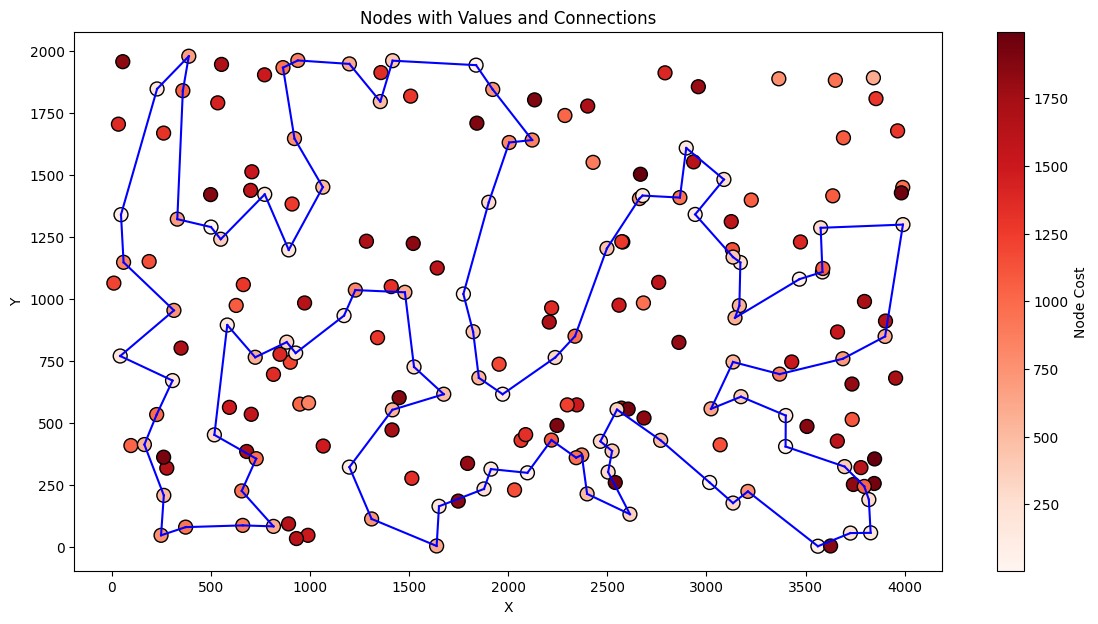

Acheived Total Score: 69207


------------- Similarity Plots -------------




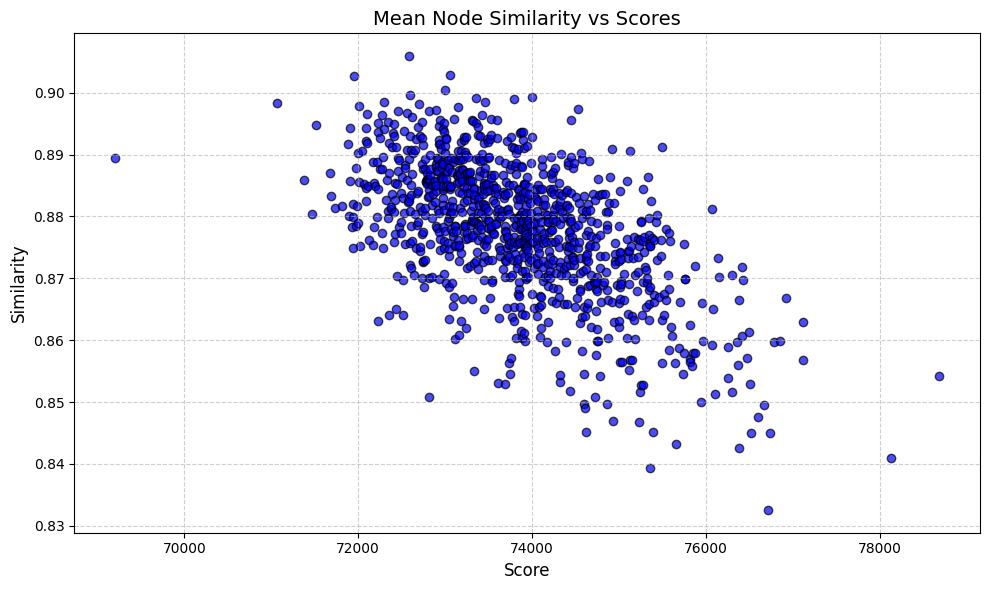

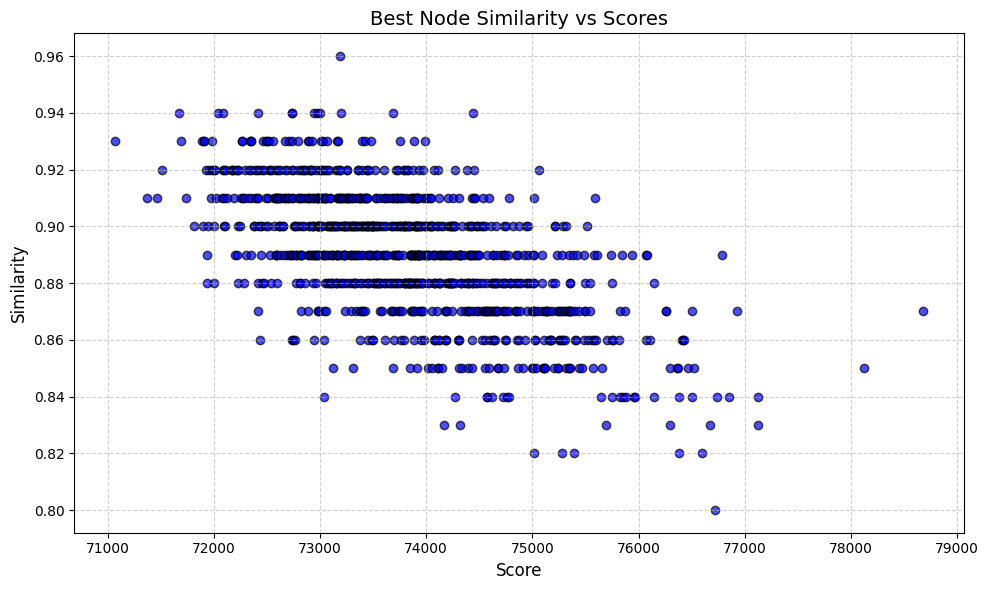

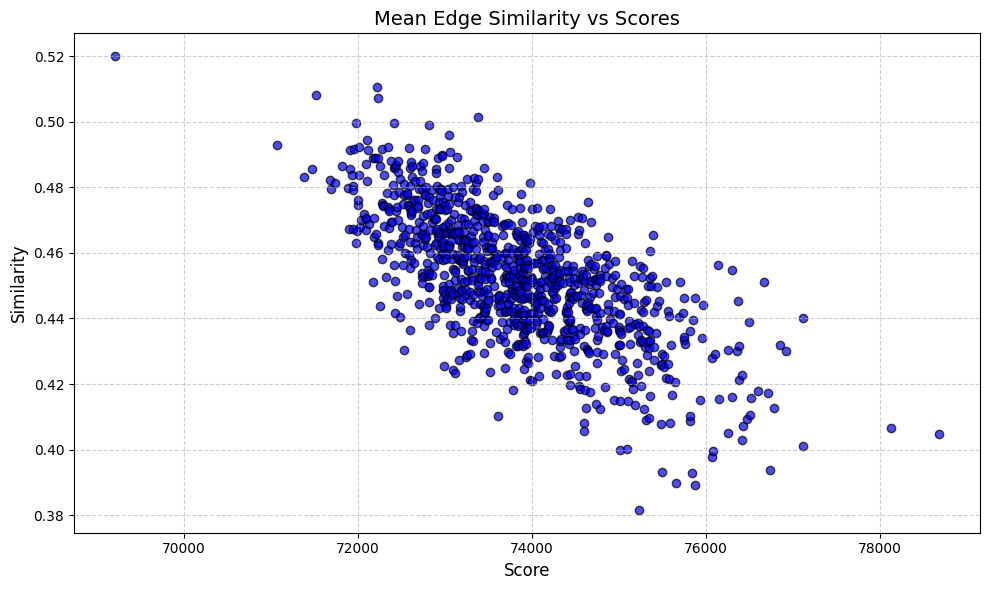

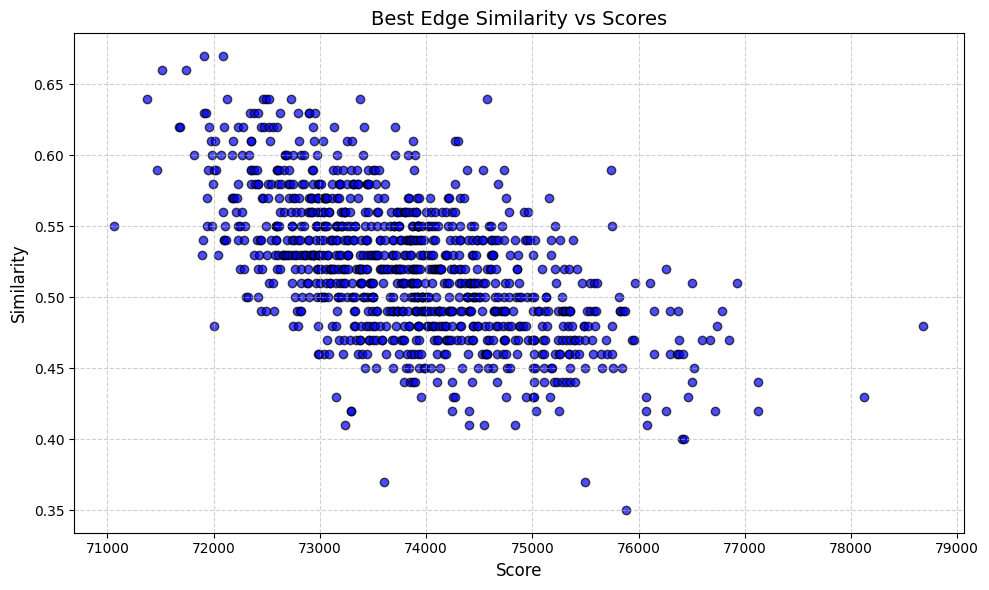

Correlation between Score and Mean Node Similarity: -0.5854875104431091
Correlation between Score and Best Node Similarity: -0.6239532595599057
Correlation between Score and Mean Edge Similarity: -0.6937988596502084
Correlation between Score and Best Edge Similarity: -0.5842222882845315


In [18]:
print("------------------------------------------")
print("***        Best Result Overall        ***")
print("------------------------------------------")

best_sol, best_sc = results[0]
plot_nodes_with_lines(df_A, best_sol)
print(f"Acheived Total Score: {best_sc}")

print("\n\n------------- Similarity Plots -------------\n\n")

similarity_results_nodes, similarity_results_edges = run_similarity_tests(results)
mean_similarity_nodes = get_similarity_average(similarity_results_nodes)
best_similarity_nodes = get_similarity_to_best(similarity_results_nodes)
mean_similarity_edges = get_similarity_average(similarity_results_edges)
best_similarity_edges = get_similarity_to_best(similarity_results_edges)

best_similarity_nodes = best_similarity_nodes[1: ]
best_similarity_edges = best_similarity_edges[1: ]

mean_similarity_nodes_scores = combine_scores_similarities(mean_similarity_nodes, results)
best_similarity_nodes_scores = combine_scores_similarities(best_similarity_nodes, results[1: ])
mean_similarity_edges_scores = combine_scores_similarities(mean_similarity_edges, results)
best_similarity_edges_scores = combine_scores_similarities(best_similarity_edges, results[1: ])

plot_similarities(mean_similarity_nodes_scores, "Mean Node Similarity vs Scores")
plot_similarities(best_similarity_nodes_scores, "Best Node Similarity vs Scores")
plot_similarities(mean_similarity_edges_scores, "Mean Edge Similarity vs Scores")
plot_similarities(best_similarity_edges_scores, "Best Edge Similarity vs Scores")

mean_nodes_corr = calculate_correlation(mean_similarity_nodes_scores)
best_nodes_corr = calculate_correlation(best_similarity_nodes_scores)
mean_edges_corr = calculate_correlation(mean_similarity_edges_scores)
best_edges_corr = calculate_correlation(best_similarity_edges_scores)

print("Correlation between Score and Mean Node Similarity:", mean_nodes_corr)
print("Correlation between Score and Best Node Similarity:", best_nodes_corr)
print("Correlation between Score and Mean Edge Similarity:", mean_edges_corr)
print("Correlation between Score and Best Edge Similarity:", best_edges_corr)

### TSPB

In [19]:
df_B = pd.read_csv(TSPB_PATH, sep=";", header=None)
df_B.columns = ["x", "y", "val"]
distance_matrix_B = get_distance_matrix(df_B, euclidean_distance)
weights_B = df_B.val.to_numpy()

In [20]:
allowed_time = 200

initial_best_solution = None
initial_best_score = np.inf

for i in range(5):
    temp_sol, temp_score, iterations = Large_Neighborhood_Search(distance_matrix_B, weights_B, initial_algorithm=random_solution, \
                                                            steepest_algorithm=deltas_steepest_local_search_edges, \
                                                            num_nodes=len(weights_B)//2, allowed_time=allowed_time, \
                                                            destroy=destroy, repair=repair_weighted_regret, \
                                                            optional_steepest=True, df=df_B)
    if temp_score < initial_best_score:
        initial_best_score = temp_score
        initial_best_solution = temp_sol.copy()

print(f"Score of the initial, best solution: {initial_best_score}")

results = run_1000_tests(initial_best_score, initial_best_solution, random_solution, greedy_local_search_edges, distance_matrix_B, weights_B)

Score of the initial, best solution: 43873


------------------------------------------
***        Best Result Overall        ***
------------------------------------------


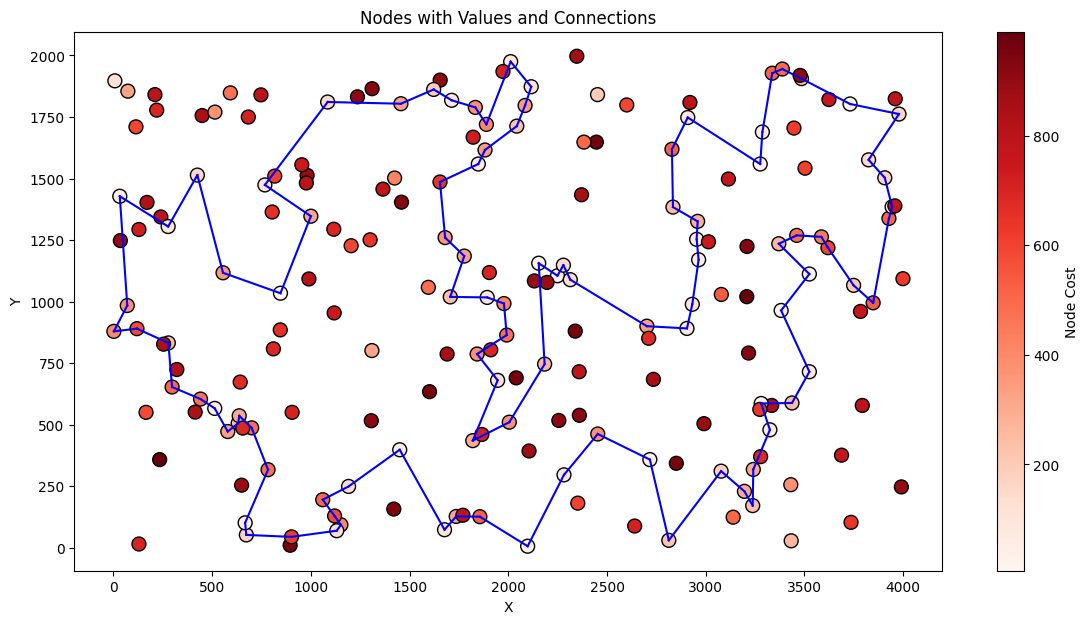

Acheived Total Score: 43873


------------- Similarity Plots -------------




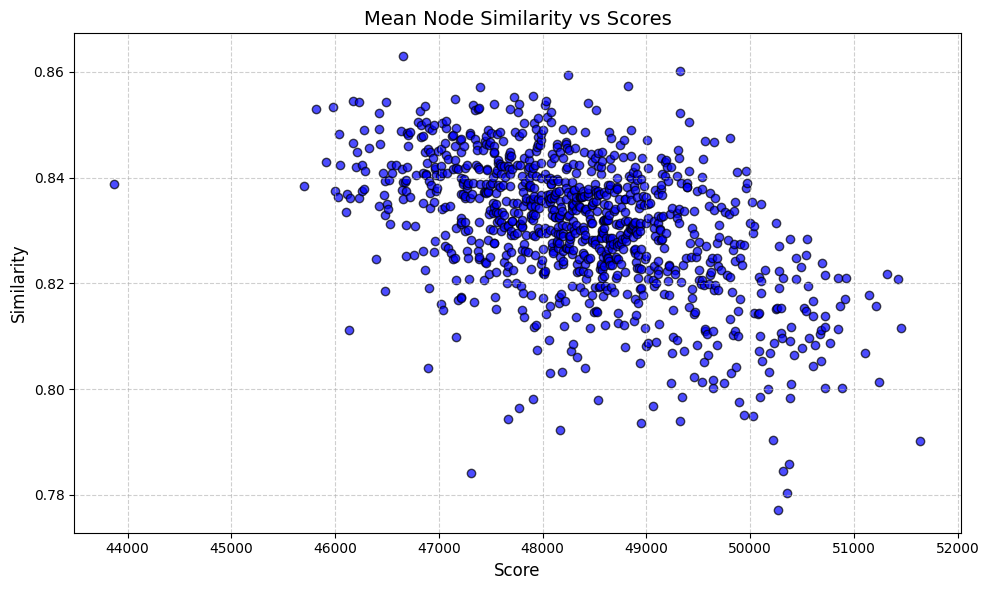

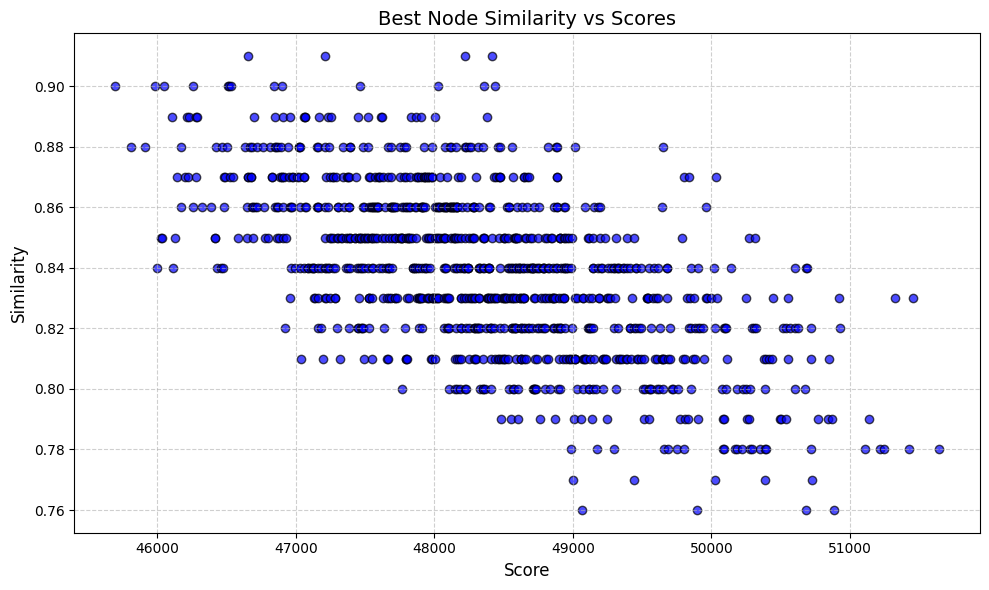

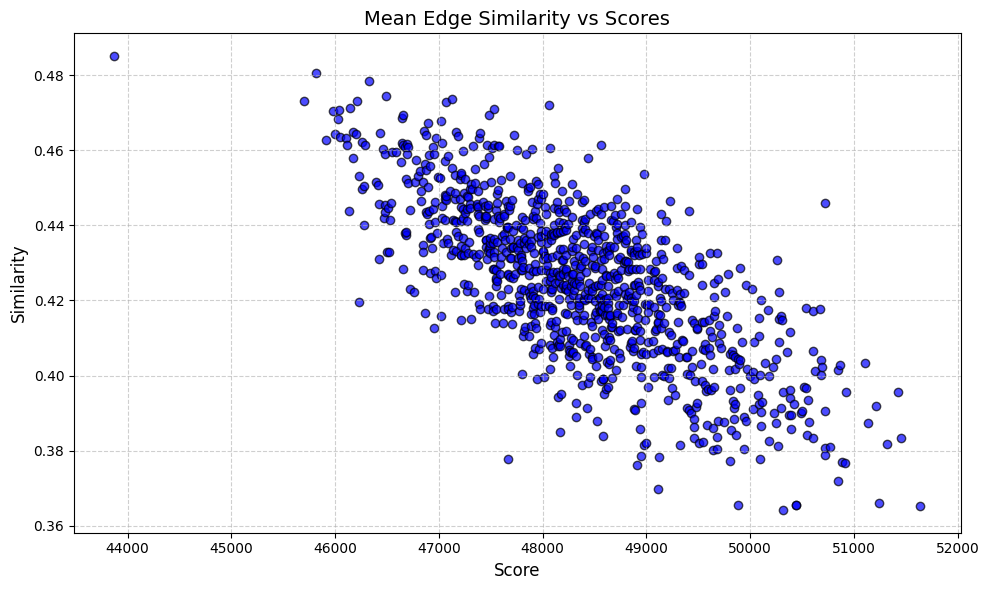

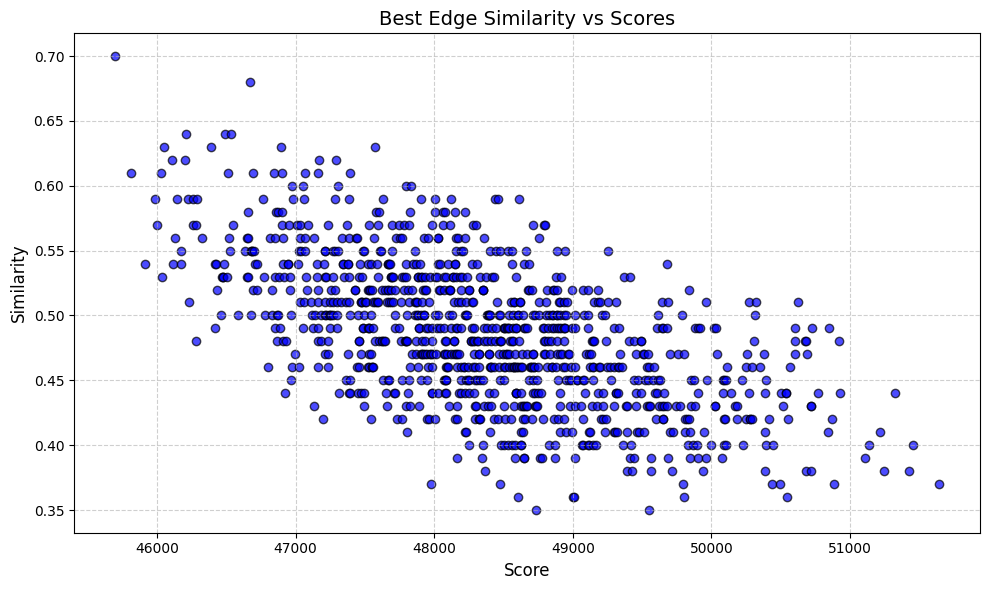

Correlation between Score and Mean Node Similarity: -0.5106024131354377
Correlation between Score and Best Node Similarity: -0.6195634428414426
Correlation between Score and Mean Edge Similarity: -0.728855273796923
Correlation between Score and Best Edge Similarity: -0.6024364339049111


In [21]:
print("------------------------------------------")
print("***        Best Result Overall        ***")
print("------------------------------------------")

best_sol, best_sc = results[0]
plot_nodes_with_lines(df_B, best_sol)
print(f"Acheived Total Score: {best_sc}")

print("\n\n------------- Similarity Plots -------------\n\n")

similarity_results_nodes, similarity_results_edges = run_similarity_tests(results)
mean_similarity_nodes = get_similarity_average(similarity_results_nodes)
best_similarity_nodes = get_similarity_to_best(similarity_results_nodes)
mean_similarity_edges = get_similarity_average(similarity_results_edges)
best_similarity_edges = get_similarity_to_best(similarity_results_edges)

best_similarity_nodes = best_similarity_nodes[1: ]
best_similarity_edges = best_similarity_edges[1: ]

mean_similarity_nodes_scores = combine_scores_similarities(mean_similarity_nodes, results)
best_similarity_nodes_scores = combine_scores_similarities(best_similarity_nodes, results[1: ])
mean_similarity_edges_scores = combine_scores_similarities(mean_similarity_edges, results)
best_similarity_edges_scores = combine_scores_similarities(best_similarity_edges, results[1: ])

plot_similarities(mean_similarity_nodes_scores, "Mean Node Similarity vs Scores")
plot_similarities(best_similarity_nodes_scores, "Best Node Similarity vs Scores")
plot_similarities(mean_similarity_edges_scores, "Mean Edge Similarity vs Scores")
plot_similarities(best_similarity_edges_scores, "Best Edge Similarity vs Scores")

mean_nodes_corr = calculate_correlation(mean_similarity_nodes_scores)
best_nodes_corr = calculate_correlation(best_similarity_nodes_scores)
mean_edges_corr = calculate_correlation(mean_similarity_edges_scores)
best_edges_corr = calculate_correlation(best_similarity_edges_scores)

print("Correlation between Score and Mean Node Similarity:", mean_nodes_corr)
print("Correlation between Score and Best Node Similarity:", best_nodes_corr)
print("Correlation between Score and Mean Edge Similarity:", mean_edges_corr)
print("Correlation between Score and Best Edge Similarity:", best_edges_corr)